In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 100
sample_range = range(0, 100)

Sparse Bayesian Learning (SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.25, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.37s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.23s/it]

Converged after 462 outer iterations



Processing Samples:   1%|          | 1/100 [01:46<2:54:55, 106.02s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.92s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.52s/it]

Converged after 453 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:29<2:51:03, 104.73s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.20s/it]

Converged after 360 outer iterations



Processing Samples:   3%|▎         | 3/100 [05:12<2:47:26, 103.58s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:39, 19.56s/it]

Converged after 498 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.74s/it]

Converged after 472 outer iterations



Processing Samples:   4%|▍         | 4/100 [06:58<2:47:39, 104.78s/it]

Converged after 308 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:05, 16.39s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.91s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.97s/it]

Converged after 347 outer iterations



Processing Samples:   5%|▌         | 5/100 [08:38<2:43:13, 103.09s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.64s/it]

Converged after 461 outer iterations



Processing Samples:   6%|▌         | 6/100 [10:22<2:41:39, 103.18s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.67s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.24s/it]

Converged after 314 outer iterations



Processing Samples:   7%|▋         | 7/100 [11:59<2:36:56, 101.25s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.99s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.33s/it]

Converged after 396 outer iterations



Processing Samples:   8%|▊         | 8/100 [13:43<2:36:32, 102.09s/it]

Converged after 444 outer iterations



Processing Samples:   9%|▉         | 9/100 [15:30<2:37:02, 103.54s/it]

Converged after 332 outer iterations



Processing Samples:  10%|█         | 10/100 [17:17<2:37:19, 104.89s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.98s/it]

Converged after 470 outer iterations



Processing Samples:  11%|█         | 11/100 [19:02<2:35:15, 104.67s/it]

Converged after 360 outer iterations



Processing Samples:  12%|█▏        | 12/100 [20:46<2:33:16, 104.51s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.09s/it]

Converged after 367 outer iterations



Processing Samples:  13%|█▎        | 13/100 [22:25<2:29:20, 102.99s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.28s/it]

Converged after 452 outer iterations



Processing Samples:  14%|█▍        | 14/100 [24:10<2:28:33, 103.64s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.49s/it]

Converged after 354 outer iterations



Processing Samples:  15%|█▌        | 15/100 [25:49<2:24:40, 102.12s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.27s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.19s/it]

Converged after 456 outer iterations



Processing Samples:  16%|█▌        | 16/100 [27:30<2:22:29, 101.78s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.20s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.18s/it]

Converged after 328 outer iterations



Processing Samples:  17%|█▋        | 17/100 [29:02<2:16:50, 98.92s/it] 

Converged after 294 outer iterations



Processing Samples:  18%|█▊        | 18/100 [30:49<2:18:32, 101.38s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.36s/it]

Converged after 321 outer iterations



Processing Samples:  19%|█▉        | 19/100 [32:30<2:16:38, 101.21s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.52s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.81s/it]

Converged after 346 outer iterations



Processing Samples:  20%|██        | 20/100 [34:04<2:12:06, 99.08s/it] 

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.58s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.98s/it]

Converged after 498 outer iterations



Processing Samples:  21%|██        | 21/100 [35:47<2:11:56, 100.21s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.43s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.96s/it]

Converged after 428 outer iterations



Processing Samples:  22%|██▏       | 22/100 [37:28<2:10:27, 100.35s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.52s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 16.00s/it]

Converged after 393 outer iterations



Processing Samples:  23%|██▎       | 23/100 [39:06<2:08:00, 99.75s/it] 

Converged after 436 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.42s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.74s/it]

Converged after 377 outer iterations



Processing Samples:  24%|██▍       | 24/100 [40:47<2:06:46, 100.09s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.29s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.32s/it]

Converged after 295 outer iterations



Processing Samples:  25%|██▌       | 25/100 [42:22<2:03:04, 98.46s/it] 

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.47s/it]

Converged after 361 outer iterations



Processing Samples:  26%|██▌       | 26/100 [44:03<2:02:22, 99.22s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:55, 18.52s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.05s/it]

Converged after 399 outer iterations



Processing Samples:  27%|██▋       | 27/100 [45:45<2:01:45, 100.07s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.37s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.76s/it]

Converged after 452 outer iterations



Processing Samples:  28%|██▊       | 28/100 [47:28<2:01:16, 101.06s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:35, 17.70s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.79s/it]

Converged after 432 outer iterations



Processing Samples:  29%|██▉       | 29/100 [49:13<2:00:56, 102.21s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.50s/it]

Converged after 406 outer iterations



Processing Samples:  30%|███       | 30/100 [50:53<1:58:30, 101.57s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.19s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.69s/it]

Converged after 417 outer iterations



Processing Samples:  31%|███       | 31/100 [52:31<1:55:38, 100.56s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.03s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.15s/it]

Converged after 362 outer iterations



Processing Samples:  32%|███▏      | 32/100 [54:09<1:52:58, 99.69s/it] 

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:19, 19.04s/it]

Converged after 477 outer iterations



Processing Samples:  33%|███▎      | 33/100 [55:54<1:53:16, 101.44s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:18, 18.20s/it]

Converged after 418 outer iterations



Processing Samples:  34%|███▍      | 34/100 [57:35<1:51:17, 101.17s/it]

Converged after 332 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.38s/it]

Converged after 357 outer iterations



Processing Samples:  35%|███▌      | 35/100 [59:15<1:49:11, 100.79s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.73s/it]

Converged after 377 outer iterations



Processing Samples:  36%|███▌      | 36/100 [1:00:54<1:47:01, 100.34s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.37s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.67s/it]

Converged after 440 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:02:30<1:44:00, 99.06s/it] 

Converged after 317 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.36s/it]

Converged after 465 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:04:14<1:43:46, 100.43s/it]

Converged after 370 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:06:00<1:43:54, 102.20s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.78s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:15, 15.75s/it]

Converged after 297 outer iterations



Processing Samples:  40%|████      | 40/100 [1:07:39<1:41:03, 101.06s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.33s/it]

Converged after 404 outer iterations



Processing Samples:  41%|████      | 41/100 [1:09:30<1:42:16, 104.02s/it]

Converged after 442 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:11:21<1:42:47, 106.34s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:32<01:03, 15.94s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:48<00:48, 16.31s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.05s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.50s/it]

Converged after 370 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:12:55<1:37:17, 102.42s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.78s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.54s/it]

Converged after 443 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:16:24<1:34:38, 103.24s/it]

Converged after 315 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.78s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.19s/it]

Converged after 446 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:18:05<1:32:21, 102.61s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.72s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.46s/it]

Converged after 422 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:19:46<1:30:03, 101.96s/it]

Converged after 381 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:21:34<1:30:02, 103.89s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.49s/it]

Converged after 390 outer iterations
Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.92s/it]

Converged after 402 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:24:55<1:25:09, 102.20s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.75s/it]

Converged after 477 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:26:44<1:25:09, 104.28s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.29s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.23s/it]

Converged after 365 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:28:23<1:22:00, 102.51s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.22s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.36s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.84s/it]

Converged after 423 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:30:02<1:19:37, 101.64s/it]

Converged after 310 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:31:48<1:18:52, 102.89s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.98s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.33s/it]

Converged after 388 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:33:32<1:17:19, 103.09s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.40s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.04s/it]

Converged after 397 outer iterations
Converged after 395 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.78s/it]

Converged after 374 outer iterations



Processing Samples:  57%|█████▋    | 57/100 [1:36:56<1:13:52, 103.09s/it]

Converged after 390 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [1:38:45<1:13:24, 104.88s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.75s/it]

Converged after 418 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [1:40:31<1:11:52, 105.19s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.64s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.30s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.44s/it]

Converged after 382 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:44:02<1:08:12, 104.93s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:54, 18.29s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.71s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.19s/it]

Converged after 490 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:45:43<1:05:43, 103.77s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.33s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.84s/it]

Converged after 373 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [1:47:19<1:02:35, 101.49s/it]

Converged after 297 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.02s/it]

Converged after 398 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [1:48:59<1:00:37, 101.03s/it]

Converged after 265 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:50:43<59:25, 101.88s/it]  

Converged after 281 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.78s/it]

Converged after 499 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [1:52:27<58:04, 102.49s/it]

Converged after 298 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.80s/it]

Converged after 404 outer iterations



Processing Samples:  67%|██████▋   | 67/100 [1:54:10<56:34, 102.86s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.95s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.79s/it]

Converged after 413 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [1:55:56<55:18, 103.69s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.27s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.39s/it]

Converged after 481 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [1:57:42<53:57, 104.44s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:50, 16.97s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.38s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.68s/it]

Converged after 447 outer iterations



Processing Samples:  70%|███████   | 70/100 [1:59:23<51:42, 103.42s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.50s/it]

Converged after 397 outer iterations



Processing Samples:  71%|███████   | 71/100 [2:01:02<49:16, 101.94s/it]

Converged after 275 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.89s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.98s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.84s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.60s/it]

Converged after 485 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [2:04:40<47:20, 105.22s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.87s/it]

Converged after 449 outer iterations



Processing Samples:  74%|███████▍  | 74/100 [2:06:28<45:59, 106.13s/it]

Converged after 445 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:08:25<45:35, 109.41s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:51, 17.27s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.02s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.56s/it]

Converged after 364 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:10:01<42:08, 105.36s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.74s/it]

Converged after 417 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:11:46<40:18, 105.17s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.35s/it]

Converged after 392 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:13:30<38:25, 104.82s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.26s/it]

Converged after 383 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:15:12<36:24, 104.01s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.39s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.69s/it]

Converged after 363 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:16:49<33:58, 101.91s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.75s/it]

Converged after 440 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:18:42<33:22, 105.41s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.28s/it]

Converged after 404 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:20:27<31:32, 105.16s/it]

Converged after 299 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.80s/it]

Converged after 488 outer iterations
Converged after 385 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:22:11<29:40, 104.76s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.72s/it]

Converged after 418 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [2:23:52<27:38, 103.65s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.60s/it]

Converged after 446 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:25:35<25:51, 103.42s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.40s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.26s/it]

Converged after 377 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:27:20<24:15, 103.99s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.03s/it]

Converged after 362 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:29:04<22:30, 103.91s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.75s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.89s/it]

Converged after 399 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:30:44<20:33, 102.82s/it]

Converged after 329 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.32s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.43s/it]

Converged after 369 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:32:29<18:59, 103.60s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.34s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.31s/it]

Converged after 373 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:34:07<16:58, 101.83s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.02s/it]

Converged after 376 outer iterations



Processing Samples:  91%|█████████ | 91/100 [2:35:53<15:26, 102.91s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.51s/it]

Converged after 335 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [2:37:33<13:36, 102.10s/it]

Converged after 320 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:54, 18.08s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.96s/it]

Converged after 444 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:39:17<11:58, 102.68s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.32s/it]

Converged after 427 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [2:41:07<10:29, 104.86s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.66s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.42s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.04s/it]

Converged after 310 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [2:44:34<06:53, 103.34s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.76s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.08s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.11s/it]

Converged after 395 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:48:05<03:28, 104.38s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.28s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.23s/it]

Converged after 460 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [2:49:50<01:44, 104.52s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.71s/it]

Converged after 405 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:51:35<00:00, 102.95s/it]

Converged after 354 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [66.65 87.5  97.5  99.45 99.8  99.75]
Avg SRR : [0.3873759  0.62459866 0.81109984 0.90579947 0.94534256 0.9626381 ]
Avg FR  : [2.88947368 1.90526316 1.01578947 0.52105263 0.29473684 0.18947368]
Avg PR  : [0.55305884 0.71761161 0.84085153 0.91353273 0.9488977  0.96691295]
Avg RE  : [0.6665 0.875  0.975  0.9945 0.998  0.9975]
Avg F1  : [0.60348845 0.78683616 0.90140975 0.95129353 0.97228528 0.98152278]
Avg NMSE: [0.56758737 0.32681137 0.15251522 0.09100917 0.06415652 0.0508545 ]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-1-25-beta-0-10-snr-db-12-pilot-length-all.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


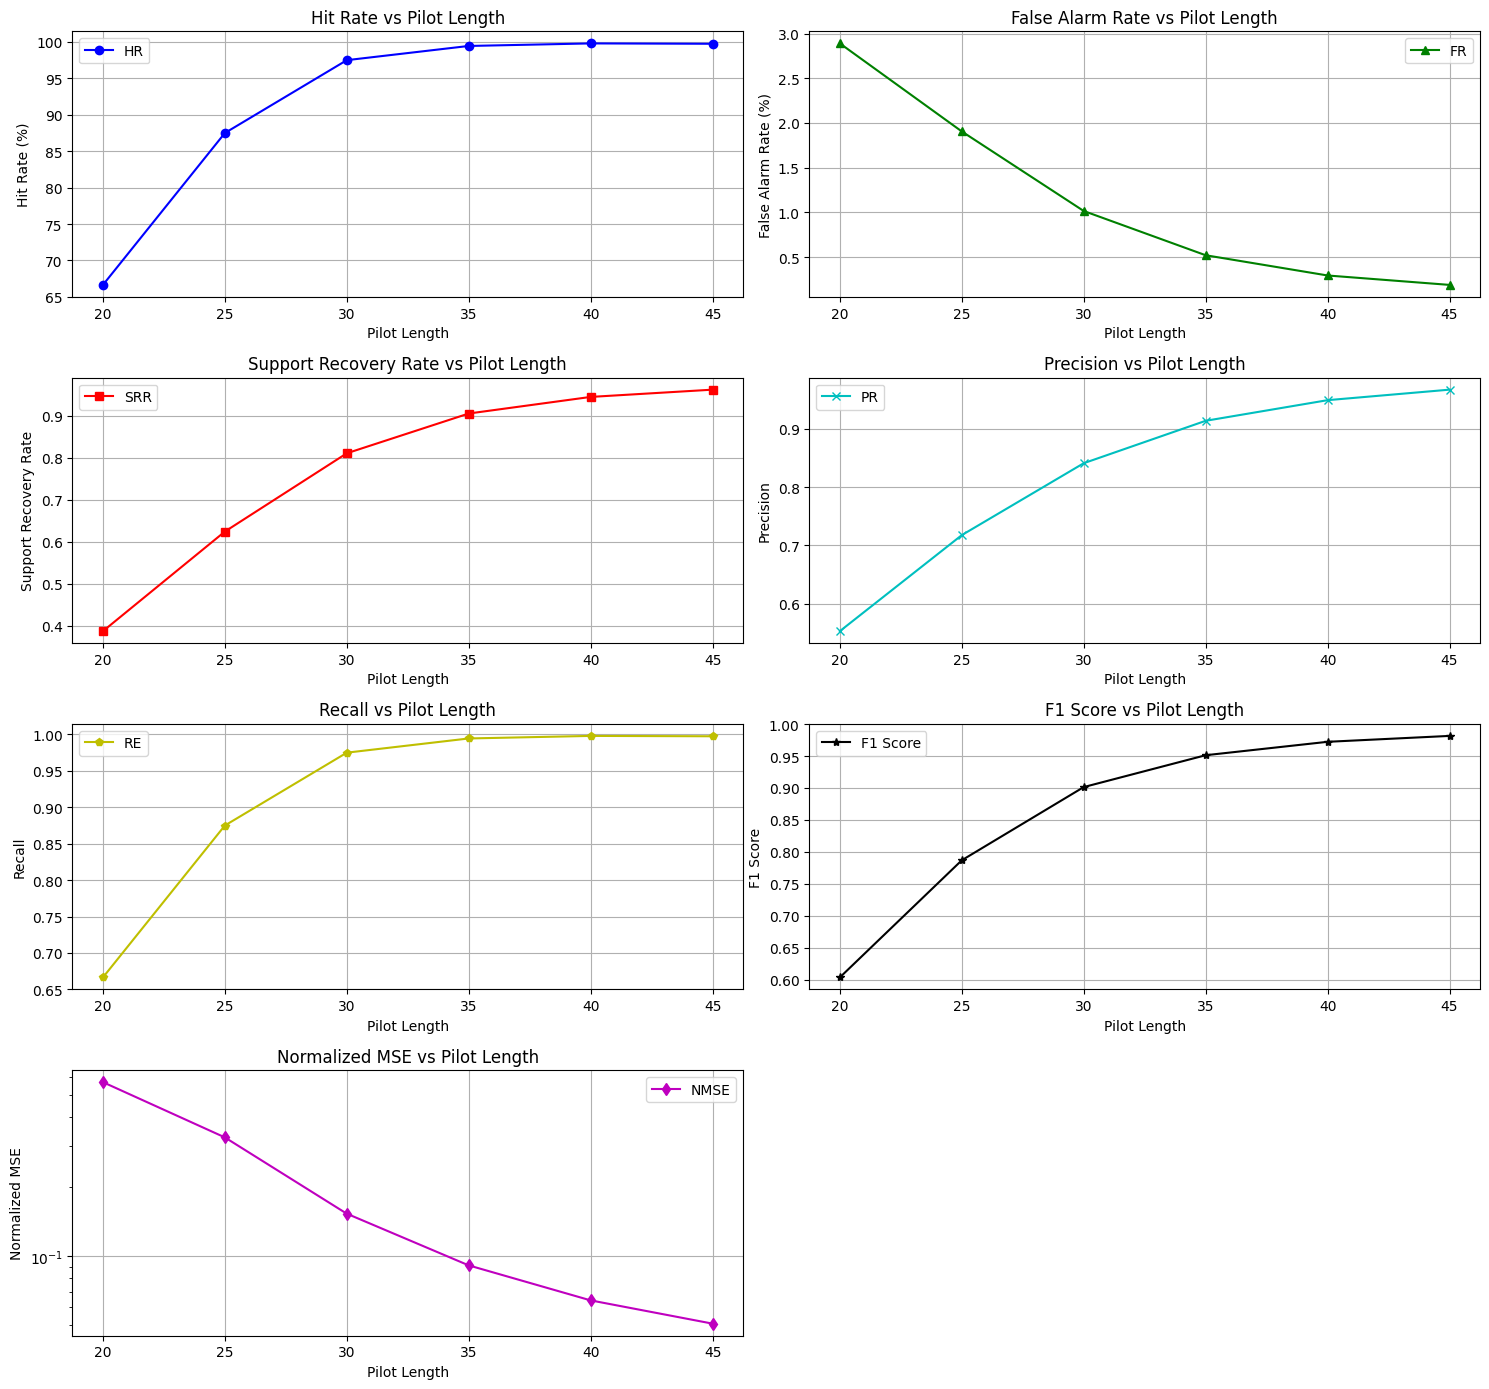

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

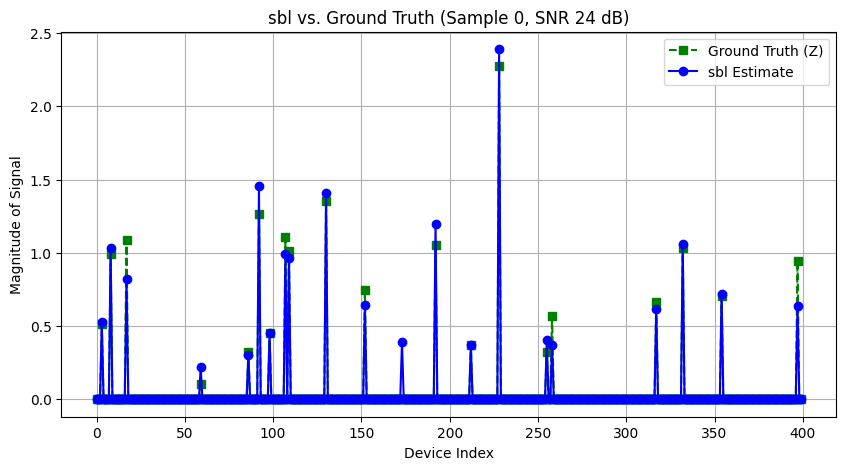

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


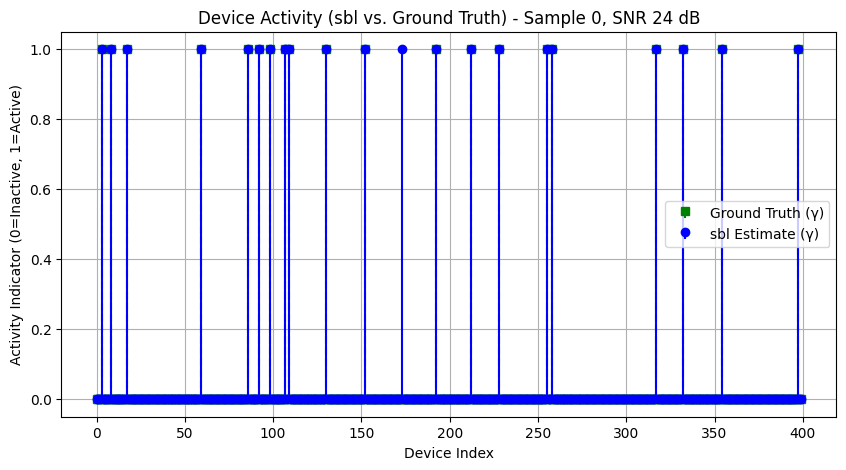

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)